In [ ]:
!nvidia-smi

Tue Nov 18 01:37:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   45C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"사용 가능 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.8.0+cu126
CUDA available: True
사용 가능 메모리: 22.16 GB
CUDA version: 12.6


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터셋 확인

In [ ]:
import json
import pandas as pd
from datasets import Dataset

# JSONL 파일 경로
train_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_train_1110.jsonl'
valid_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_valid_1110.jsonl'
test_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_test_1110.jsonl'

# JSONL 로드 함수
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# 데이터 로드
train_data = load_jsonl(train_path)
valid_data = load_jsonl(valid_path)
test_data = load_jsonl(test_path)

print(f"데이터 로드 완료!")
print(f"- Train: {len(train_data)}개")
print(f"- Valid: {len(valid_data)}개")
print(f"- Test: {len(test_data)}개")

데이터 로드 완료!
- Train: 2561개
- Valid: 320개
- Test: 321개


In [ ]:
# 첫 번째 샘플 확인
print("=== Train 샘플 1개 ===\n")
sample = train_data[0]
print(json.dumps(sample, indent=2, ensure_ascii=False))

print("\n=== Messages 구조 ===")
for msg in sample['messages']:
    print(f"\nRole: {msg['role']}")
    print(f"Content: {msg['content'][:100]}..." if len(msg['content']) > 100 else f"Content: {msg['content']}")

=== Train 샘플 1개 ===

{
  "messages": [
    {
      "role": "system",
      "content": "You are an AI system that determines if the question requires clarification and classifies the ambiguity.\n\nTask:\n1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)\n2. Classify the ambiguity:\n   - If question is clear, set category=NONE and subclass=NONE\n   - If question is ambiguous, classify category and subclass\n\nOutput format: category|subclass\n\nCategories:\n- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions\n- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity\n- AO (Aleatoric Output): Questions with missing contextual information causing confusion\n- NONE: Clear questions that don't require clarification\n\nSubclasses:\nFor EM:\n- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts\n- CONT (CONTRADICTION): Query contains self-contradictions\n\nFor LA:

In [ ]:
def format_chat_prompt(sample):
    """
    messages 형식을 Llama 2 Chat 프롬프트로 변환
    """
    messages = sample['messages']

    # system, user, assistant 메시지 추출
    system_msg = None
    user_msg = None
    assistant_msg = None

    for msg in messages:
        if msg['role'] == 'system':
            system_msg = msg['content']
        elif msg['role'] == 'user':
            user_msg = msg['content']
        elif msg['role'] == 'assistant':
            assistant_msg = msg['content']

    # Llama 2 Chat 형식으로 조합
    if system_msg:
        prompt = f"<s>[INST] <<SYS>>\n{system_msg}\n<</SYS>>\n\n{user_msg} [/INST]"
    else:
        prompt = f"<s>[INST] {user_msg} [/INST]"

    # 전체 텍스트 (학습용: 프롬프트 + 답변)
    full_text = f"{prompt} {assistant_msg} </s>"

    return {
        'prompt': prompt,
        'response': assistant_msg,
        'full_text': full_text
    }

# 테스트
formatted = format_chat_prompt(train_data[0])

print("=== 변환된 프롬프트 ===\n")
print(formatted['prompt'])
print("\n=== 기대 답변 ===")
print(formatted['response'])
print("\n=== 전체 텍스트 (학습용) ===")
print(formatted['full_text'][:300] + "...")

=== 변환된 프롬프트 ===

<s>[INST] <<SYS>>
You are an AI system that determines if the question requires clarification and classifies the ambiguity.

Task:
1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)
2. Classify the ambiguity:
   - If question is clear, set category=NONE and subclass=NONE
   - If question is ambiguous, classify category and subclass

Output format: category|subclass

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query contains terms with multiple meanings
- SEM (SEM

In [ ]:
# 프롬프트 토큰화
sample_formatted = format_chat_prompt(train_data[0])

# 프롬프트만 인코딩
prompt_tokens = tokenizer.encode(sample_formatted['prompt'], add_special_tokens=False)
print(f"프롬프트 토큰 길이: {len(prompt_tokens)}")

# 전체 텍스트 인코딩
full_tokens = tokenizer.encode(sample_formatted['full_text'], add_special_tokens=False)
print(f"전체 텍스트 토큰 길이: {len(full_tokens)}")

# 답변만의 토큰 길이
response_length = len(full_tokens) - len(prompt_tokens)
print(f"답변 토큰 길이: {response_length}")

# 디코딩 확인
decoded = tokenizer.decode(full_tokens)
print(f"\n=== 디코딩 결과 ===")
print(decoded[:500])

NameError: name 'tokenizer' is not defined

모델 테스트

In [ ]:
!pip install -q bitsandbytes>=0.43.0

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from peft import prepare_model_for_kbit_training
import gc

# GPU 메모리 확인
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

CUDA available: True
GPU: NVIDIA L4
Memory: 23.80 GB


In [ ]:
from huggingface_hub import login
# huggingface 토큰을 입력
login("토큰 입력")

In [ ]:
# 모델 이름
model_name = "meta-llama/Llama-2-7b-chat-hf"

# 8-bit 양자화 설정 (메모리 절약)
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16,
    bnb_8bit_use_double_quant=True,
)

print("모델 로딩 중...")
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
)

print("모델 로드 완료")
print(f"모델 파라미터 수: {model.num_parameters() / 1e9:.2f}B")

모델 로딩 중...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

모델 로드 완료
모델 파라미터 수: 6.74B


In [ ]:
# 토크나이저 로드
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
)

# padding 토큰 설정 (Llama는 기본적으로 없음)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print("✓ 토크나이저 로드 완료")
print(f"\n토크나이저 정보:")
print(f"- Vocab size: {len(tokenizer)}")
print(f"- BOS token: {tokenizer.bos_token} (ID: {tokenizer.bos_token_id})")
print(f"- EOS token: {tokenizer.eos_token} (ID: {tokenizer.eos_token_id})")
print(f"- PAD token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")
print(f"- UNK token: {tokenizer.unk_token}")

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

✓ 토크나이저 로드 완료

토크나이저 정보:
- Vocab size: 32000
- BOS token: <s> (ID: 1)
- EOS token: </s> (ID: 2)
- PAD token: </s> (ID: 2)
- UNK token: <unk>


In [ ]:
# 테스트 프롬프트 (데이터셋 형식과 유사하게)
test_prompt = """<s>[INST] <<SYS>>
You are an AI system that determines if the question requires clarification and classifies the ambiguity.

Task:
1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)
2. Classify the ambiguity:
   - If question is clear, set category=NONE and subclass=NONE
   - If question is ambiguous, classify category and subclass

Output format: category|subclass
<</SYS>>

Number of starbucks stores in the united states? [/INST]"""

# 토크나이저로 인코딩
inputs = tokenizer(test_prompt, return_tensors="pt").to(model.device)

print(f"입력 토큰 길이: {inputs['input_ids'].shape[1]}")
print("\n생성 중...")

# 모델 출력 생성
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=20,
        temperature=0.1,
        do_sample=True,
        top_p=0.9,
    )

# 디코딩
response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("\n=== 모델 출력 (파인튜닝 전) ===")
print(response)

# 생성된 부분만 추출
generated_text = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print("\n=== 생성된 답변만 ===")
print(generated_text)

입력 토큰 길이: 138

생성 중...

=== 모델 출력 (파인튜닝 전) ===
[INST] <<SYS>>
You are an AI system that determines if the question requires clarification and classifies the ambiguity.

Task:
1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)
2. Classify the ambiguity:
   - If question is clear, set category=NONE and subclass=NONE
   - If question is ambiguous, classify category and subclass

Output format: category|subclass
<</SYS>>

Number of starbucks stores in the united states? [/INST]  Sure, I'd be happy to help! Here's my analysis of the question:

=== 생성된 답변만 ===
 Sure, I'd be happy to help! Here's my analysis of the question:


In [ ]:
# [INST]가 어떻게 토큰화되는지 확인
test_text = "[INST]"
tokens = tokenizer.encode(test_text)
print(f"'[INST]' 토큰화: {tokens}")
print(f"토큰 디코드: {[tokenizer.decode([t]) for t in tokens]}")

# 비교: 실제 special token
tokens_bos = tokenizer.encode("<s>", add_special_tokens=False)
print(f"\n'<s>' 토큰화: {tokens_bos}")

'[INST]' 토큰화: [1, 518, 25580, 29962]
토큰 디코드: ['<s>', '[', 'INST', ']']

'<s>' 토큰화: [1]


토크나이저로 데이터 인코딩 테스트

In [ ]:
# 프롬프트 토큰화
sample_formatted = format_chat_prompt(train_data[0])

# 프롬프트만 인코딩
prompt_tokens = tokenizer.encode(sample_formatted['prompt'], add_special_tokens=False)
print(f"프롬프트 토큰 길이: {len(prompt_tokens)}")

# 전체 텍스트 인코딩
full_tokens = tokenizer.encode(sample_formatted['full_text'], add_special_tokens=False)
print(f"전체 텍스트 토큰 길이: {len(full_tokens)}")

# 답변만의 토큰 길이
response_length = len(full_tokens) - len(prompt_tokens)
print(f"답변 토큰 길이: {response_length}")

# 디코딩 확인
decoded = tokenizer.decode(full_tokens)
print(f"\n=== 디코딩 결과 ===")
print(decoded)

프롬프트 토큰 길이: 375
전체 텍스트 토큰 길이: 382
답변 토큰 길이: 7

=== 디코딩 결과 ===
<s> [INST] <<SYS>>
You are an AI system that determines if the question requires clarification and classifies the ambiguity.

Task:
1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)
2. Classify the ambiguity:
   - If question is clear, set category=NONE and subclass=NONE
   - If question is ambiguous, classify category and subclass

Output format: category|subclass

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query con

In [ ]:
# 테스트용 샘플 3개
test_samples = train_data[:3]

print("=== 파인튜닝 전 모델 출력 테스트 ===\n")

for idx, sample in enumerate(test_samples):
    formatted = format_chat_prompt(sample)

    # 인코딩
    inputs = tokenizer(formatted['prompt'], return_tensors="pt").to(model.device)

    # 생성
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=30,
            temperature=0.1,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    # 생성된 답변만 추출
    generated = tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)

    print(f"\n--- 샘플 {idx+1} ---")
    print(f"질문: {sample['messages'][1]['content'][:80]}...")
    print(f"기대 답변: {formatted['response']}")
    print(f"모델 출력: {generated}")
    print("-" * 50)

=== 파인튜닝 전 모델 출력 테스트 ===


--- 샘플 1 ---
질문: Number of starbucks stores in the united states?...
기대 답변: NONE|NONE
모델 출력:  category|subclass

* category: NONE
* subclass: NONE

Explanation:
This question does not require
--------------------------------------------------

--- 샘플 2 ---
질문: Where is the champions league cup final being held?...
기대 답변: AO|WHEN
모델 출력:  Category: NONE
Subclass: NONE

The question is clear and does not require any clarification. The Champions League is a
--------------------------------------------------

--- 샘플 3 ---
질문: Name some of the bravolebrities from Married to Medicine...
기대 답변: NONE|NONE
모델 출력:  Sure, I'd be happy to help!

Based on the question you provided, I would classify it as "LA -
--------------------------------------------------


포맷팅된 데이터셋 저장하기

In [ ]:
import json

# 전처리 함수 (모든 데이터 변환)
def format_all_data(data_list):
    formatted_list = []
    for sample in data_list:
        formatted = format_chat_prompt(sample)
        # full_text만 저장 (학습에 필요한 건 이것만)
        formatted_list.append({
            'text': formatted['full_text']
        })
    return formatted_list

# Train/Valid/Test 각각 변환
print("전처리 중...")
train_formatted = format_all_data(train_data)
valid_formatted = format_all_data(valid_data)
test_formatted = format_all_data(test_data)

print(f"✓ 전처리 완료")
print(f"- Train: {len(train_formatted)}개")
print(f"- Valid: {len(valid_formatted)}개")
print(f"- Test: {len(test_formatted)}개")

# JSONL로 저장
output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/'

def save_jsonl(data, filepath):
    with open(filepath, 'w', encoding='utf-8') as f:
        for item in data:
            f.write(json.dumps(item, ensure_ascii=False) + '\n')

save_jsonl(train_formatted, output_dir + 'ambiguity_train_1110_formatted.jsonl')
save_jsonl(valid_formatted, output_dir + 'ambiguity_valid_1110_formatted.jsonl')
save_jsonl(test_formatted, output_dir + 'ambiguity_test_1110_formatted.jsonl')

print("\n저장 완료!")
print(f"저장 위치: {output_dir}")

# 첫 번째 샘플 확인
print("\n=== Train 첫 샘플 확인 ===")
print(train_formatted[0]['text'][:500] + "...")

전처리 중...
✓ 전처리 완료
- Train: 2561개
- Valid: 320개
- Test: 321개

저장 완료!
저장 위치: /content/drive/MyDrive/Colab Notebooks/woke-odds/

=== Train 첫 샘플 확인 ===
<s>[INST] <<SYS>>
You are an AI system that determines if the question requires clarification and classifies the ambiguity.

Task:
1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)
2. Classify the ambiguity:
   - If question is clear, set category=NONE and subclass=NONE
   - If question is ambiguous, classify category and subclass

Output format: category|subclass

Categories:
- EM (Epistemic Misalignment): Questions with unfam...


훈련

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
import torch

In [ ]:
pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 37.6 MB/s eta 0:00:00


In [ ]:
from transformers import BitsAndBytesConfig
from huggingface_hub import login

# 로그인
login("토큰 입력")

model_name = "meta-llama/Llama-2-7b-chat-hf"

# 8-bit 설정
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.float16,
    bnb_8bit_use_double_quant=True,
)

# 토크나이저 (이미 로드했으면 스킵)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# 모델 (이미 로드했으면 스킵)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    use_cache=False  # Gradient checkpointing 호환
)

print("모델 준비 완료")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

모델 준비 완료


In [ ]:
# LoRA Config 설정

from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# 8-bit 학습 준비
model = prepare_model_for_kbit_training(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Llama 2 구조
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# requires_grad 확인
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"✅ {name}: requires_grad=True")
        break
else:
    print("학습 가능한 파라미터가 없습니다!")

trainable params: 8,388,608 || all params: 6,746,804,224 || trainable%: 0.1243
✅ base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight: requires_grad=True


In [ ]:
# 전처리된 데이터 로드
import json

def load_jsonl(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/'

# 로드
train_formatted = load_jsonl(output_dir + 'ambiguity_train_1110_formatted_balanced_none90_ao15x_unf15x.jsonl')
valid_formatted = load_jsonl(output_dir + 'ambiguity_valid_1110_formatted.jsonl')

print(f"✓ 데이터 로드 완료")
print(f"- Train: {len(train_formatted)}개")
print(f"- Valid: {len(valid_formatted)}개")

# Dataset 변환
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    'train': Dataset.from_list(train_formatted),
    'validation': Dataset.from_list(valid_formatted)
})

print(f"\n Dataset 생성 완료")

✓ 데이터 로드 완료
- Train: 2844개
- Valid: 320개

 Dataset 생성 완료


In [ ]:
# 토큰 길이 분포 확인

lengths = []
for sample in train_formatted[:100]:  # 100개 샘플 테스트
    tokens = tokenizer(sample['text'])
    lengths.append(len(tokens['input_ids']))

import numpy as np
print(f"토큰 길이 통계:")
print(f"- 최소: {min(lengths)}")
print(f"- 최대: {max(lengths)}")
print(f"- 평균: {np.mean(lengths):.1f}")
print(f"- 중간값: {np.median(lengths):.1f}")
print(f"\n512 넘는 샘플: {sum(1 for l in lengths if l > 512)}개")

토큰 길이 통계:
- 최소: 378
- 최대: 504
- 평균: 395.8
- 중간값: 385.0

512 넘는 샘플: 0개


In [ ]:
# 토크나이즈 (이미 formatted된 데이터 사용)

def preprocess_function(examples):
    # 'text' 필드에 이미 전처리된 텍스트가 있음
    model_inputs = tokenizer(
        examples['text'],
        max_length=512,
        truncation=True,
        padding=False
    )

    model_inputs["labels"] = model_inputs["input_ids"].copy()

    return model_inputs

# 토크나이즈
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

print("토크나이즈 완료")

Map:   0%|          | 0/2844 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

토크나이즈 완료


In [ ]:
# 토크나이즈 결과 확인

print("=== 토크나이즈 확인 ===")
print(f"Keys: {tokenized_dataset['train'].features}")
print(f"Sample input_ids type: {type(tokenized_dataset['train'][0]['input_ids'])}")
print(f"Sample input_ids length: {len(tokenized_dataset['train'][0]['input_ids'])}")

# 디코드해서 확인
print("\n=== 첫 번째 샘플 디코드 ===")
decoded = tokenizer.decode(tokenized_dataset['train'][0]['input_ids'])
print(decoded[:500])

=== 토크나이즈 확인 ===
Keys: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': List(Value('int64'))}
Sample input_ids type: <class 'list'>
Sample input_ids length: 378

=== 첫 번째 샘플 디코드 ===
<s><s> [INST] <<SYS>>
You are an AI system that determines if the question requires clarification and classifies the ambiguity.

Task:
1. Determine if the question requires clarification: clear(no clarification needed) or ambiguous(clarification needed)
2. Classify the ambiguity:
   - If question is clear, set category=NONE and subclass=NONE
   - If question is ambiguous, classify category and subclass

Output format: category|subclass

Categories:
- EM (Epistemic Misalignment): Questions with u


In [ ]:
# W&B 비활성화

import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# TrainingArguments 설정

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/woke-odds/llama2_classifier_none90_ao15x_unf15x',
    num_train_epochs=8,
    fp16=True,  # bfloat16 대신 fp16 사용 (8-bit 로딩과 호환)
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    max_grad_norm=1.0,
    weight_decay=0.01,
    dataloader_pin_memory=False,
    dataloader_num_workers=2,
    torch_empty_cache_steps=50,
    logging_dir='/content/drive/MyDrive/Colab Notebooks/woke-odds/logs_llama2_classifier_none90_ao15x_unf15x',
    logging_steps=25,
    eval_strategy="steps",
    eval_steps=128,
    save_steps=128,
    save_safetensors=True,
    optim="adamw_8bit",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=4,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    report_to=["tensorboard"],
)

print("✓ Training Arguments 설정 완료")

✓ Training Arguments 설정 완료


In [ ]:
# 가중치 줄거면 위 셀 말고 이거 실행
# Custom Weighted Loss Trainer

import torch
from torch import nn
from transformers import Trainer
import torch.nn.functional as F

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, tokenizer=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights  # subclass별 가중치 딕셔너리
        self.tokenizer = tokenizer

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Subclass별 가중치가 적용된 loss 계산
        """
        labels = inputs.pop("labels")

        # Forward pass
        outputs = model(**inputs)
        logits = outputs.logits

        # Shift for causal LM
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()

        # 각 샘플별로 loss 계산
        batch_size = shift_logits.size(0)
        total_loss = 0.0
        valid_samples = 0

        for i in range(batch_size):
            sample_logits = shift_logits[i]  # [seq_len, vocab_size]
            sample_labels = shift_labels[i]  # [seq_len]

            # 해당 샘플의 정답 텍스트 디코딩
            label_tokens = sample_labels[sample_labels != -100]
            if len(label_tokens) == 0:
                continue

            try:
                # 정답 텍스트 디코딩 (Llama 2: category|subclass)
                label_text = self.tokenizer.decode(label_tokens, skip_special_tokens=True).strip()

                # category|subclass에서 subclass 추출
                if '|' in label_text:
                    parts = label_text.split('|')
                    if len(parts) >= 2:
                        subclass = parts[1].strip()
                    else:
                        subclass = 'NONE'
                else:
                    subclass = 'NONE'

                # 해당 서브클래스의 가중치 가져오기
                weight = self.class_weights.get(subclass, 1.0)

            except Exception as e:
                weight = 1.0

            # Sample loss 계산
            sample_loss = F.cross_entropy(
                sample_logits,
                sample_labels,
                ignore_index=-100,
                reduction='mean'
            )

            # 가중치 적용
            total_loss += sample_loss * weight
            valid_samples += 1

        # 평균 loss
        loss = total_loss / valid_samples if valid_samples > 0 else total_loss

        return (loss, outputs) if return_outputs else loss

# 가중치 정의
class_weights_v1 = {
    'NONE': 0.6,
    'CONT': 1.0,
    'LEX': 1.0,
    'UNF': 1.2,
    'SEM': 1.5,
    'WHERE': 2.0,
    'WHAT': 1.0,
    'WHEN': 2.5,
    'WHOM': 3.0,
}

print("✓ WeightedLossTrainer 정의 완료")
print(f"클래스 가중치: {class_weights_v1}")

✓ WeightedLossTrainer 정의 완료
클래스 가중치: {'NONE': 0.6, 'CONT': 1.0, 'LEX': 1.0, 'UNF': 1.2, 'SEM': 1.5, 'WHERE': 2.0, 'WHAT': 1.0, 'WHEN': 2.5, 'WHOM': 3.0}


In [ ]:
# Custom Data Collator

from dataclasses import dataclass
from typing import Any, Dict, List
import torch

@dataclass
class DataCollatorForCausalLM:
    tokenizer: Any

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        # input_ids의 최대 길이 찾기
        max_length = max(len(f["input_ids"]) for f in features)

        batch = {
            "input_ids": [],
            "attention_mask": [],
            "labels": []
        }

        for feature in features:
            input_ids = feature["input_ids"]
            attention_mask = feature["attention_mask"]
            labels = feature["labels"]

            # 패딩 길이 계산
            padding_length = max_length - len(input_ids)

            # 오른쪽에 패딩 추가
            padded_input_ids = input_ids + [self.tokenizer.pad_token_id] * padding_length
            padded_attention_mask = attention_mask + [0] * padding_length
            padded_labels = labels + [-100] * padding_length  # -100은 loss 계산에서 무시됨

            batch["input_ids"].append(padded_input_ids)
            batch["attention_mask"].append(padded_attention_mask)
            batch["labels"].append(padded_labels)

        # 리스트를 텐서로 변환
        batch = {k: torch.tensor(v) for k, v in batch.items()}

        return batch

# Data Collator 생성
data_collator = DataCollatorForCausalLM(tokenizer=tokenizer)

print("Data Collator 생성 완료")

Data Collator 생성 완료


In [ ]:
# 테스트: Collator 동작 확인

test_features = [
    tokenized_dataset["train"][i] for i in range(2)
]

print("=== Collator 테스트 ===")
print(f"샘플 1 길이: {len(test_features[0]['input_ids'])}")
print(f"샘플 2 길이: {len(test_features[1]['input_ids'])}")

batch = data_collator(test_features)

print(f"\n배치 shape:")
print(f"input_ids: {batch['input_ids'].shape}")
print(f"attention_mask: {batch['attention_mask'].shape}")
print(f"labels: {batch['labels'].shape}")
print(f"\nlabels에서 -100 개수: {(batch['labels'] == -100).sum().item()}")

=== Collator 테스트 ===
샘플 1 길이: 378
샘플 2 길이: 404

배치 shape:
input_ids: torch.Size([2, 404])
attention_mask: torch.Size([2, 404])
labels: torch.Size([2, 404])

labels에서 -100 개수: 26


In [ ]:
# Trainer 생성

from transformers import EarlyStoppingCallback

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,  # 3번 연속 개선 없으면 중단
            early_stopping_threshold=0.001  # 최소 개선 임계값
        )
    ]
)

print("Trainer 생성 완료")

Trainer 생성 완료


/tmp/ipython-input-953748124.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# 가중치 줄 거면 위 셀 말고 이거 실행
# Trainer 생성 (Weighted Loss 적용)

from transformers import EarlyStoppingCallback

trainer = WeightedLossTrainer(  # Trainer → WeightedLossTrainer 변경
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    class_weights=class_weights_v1,  # 가중치 전달
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=3,
            early_stopping_threshold=0.01
        )
    ]
)

print("WeightedLossTrainer 생성 완료")
print("가중치가 적용된 학습이 시작됩니다!")

Trainer.tokenizer is now deprecated. You should use `Trainer.processing_class = processing_class` instead.


WeightedLossTrainer 생성 완료
가중치가 적용된 학습이 시작됩니다!


In [ ]:
# 학습 시작
print("=== 학습 시작 ===")
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.


=== 학습 시작 ===


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
128,0.333100,0.245096
256,0.124600,0.125330
384,0.108300,0.107384
512,0.101700,0.099435
640,0.095800,0.095118
768,0.094400,0.092518
896,0.088200,0.090588
1024,0.089700,0.090025
1152,0.085400,0.089323
1280,0.081600,0.089247


/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.12/dist-packages/bitsandbytes/autograd/_functions.py:181: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during q

TrainOutput(global_step=1280, training_loss=0.24524394173640757, metrics={'train_runtime': 19631.4409, 'train_samples_per_second': 1.159, 'train_steps_per_second': 0.073, 'total_flos': 3.4746852402089165e+17, 'train_loss': 0.24524394173640757, 'epoch': 7.191279887482419})

In [ ]:
# Best 모델 저장 (LoRA adapter)

save_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/llama2_classifier_none90_ao15x_unf15x_best'

print("=== 모델 저장 중 ===")
print(f"저장 위치: {save_dir}")

# LoRA adapter 저장
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

print("LoRA adapter 저장 완료")
print(f"  - adapter_model.safetensors (LoRA weights)")
print(f"  - adapter_config.json (LoRA 설정)")
print(f"  - tokenizer files")

# 학습 정보 확인
print(f"\n=== Best 모델 정보 ===")
print(f"Best eval loss: {trainer.state.best_metric}")
print(f"Best checkpoint: {trainer.state.best_model_checkpoint}")

=== 모델 저장 중 ===
저장 위치: /content/drive/MyDrive/Colab Notebooks/woke-odds/llama2_classifier_none90_ao15x_unf15x_best
LoRA adapter 저장 완료
  - adapter_model.safetensors (LoRA weights)
  - adapter_config.json (LoRA 설정)
  - tokenizer files

=== Best 모델 정보 ===
Best eval loss: 0.08924700319766998
Best checkpoint: /content/drive/MyDrive/Colab Notebooks/woke-odds/llama2_classifier_none90_ao15x_unf15x/checkpoint-1280


평가

In [ ]:
import os
import torch
import numpy as np
import re
import gc
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    logging as transformers_logging
)

In [ ]:
# 모델 경로 설정
from peft import PeftModel

base_model_name = "meta-llama/Llama-2-7b-chat-hf"
lora_path = "/content/drive/MyDrive/Colab Notebooks/woke-odds/llama2_classifier_none90_ao15x_unf15x_best"

print("=== 모델 로딩 중 ===")

# 먼저 학습이 끝났는지 확인
import os
if not os.path.exists(lora_path):
    print(f"오류: 모델 경로가 존재하지 않습니다: {lora_path}")
    print("학습이 완료되고 모델이 저장되었는지 확인하세요!")
else:
    print(f"✓ 모델 경로 확인됨: {lora_path}")
    files = os.listdir(lora_path)
    print(f"저장된 파일: {files[:5]}...")  # 처음 5개만 출력

# 토크나이저 로드 (local_files_only 추가!)
tokenizer = AutoTokenizer.from_pretrained(
    lora_path,
    local_files_only=True,  # 로컬 파일만 사용
    trust_remote_code=True
)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("✓ 토크나이저 로드 완료")

# Base 모델 로드
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)

print("✓ Base 모델 로드 완료")

# LoRA adapter 로드 (local_files_only 추가!)
model = PeftModel.from_pretrained(
    base_model,
    lora_path,
    local_files_only=True  # 로컬 파일만 사용
)

model = model.eval()

print("✓ LoRA adapter 로드 완료")
print(f"Device: {model.device}")

# 데이터 콜레이터 설정
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    padding=True,
    return_tensors="pt"
)

print("✓ 모든 로드 완료!")

=== 모델 로딩 중 ===
✓ 모델 경로 확인됨: /content/drive/MyDrive/Colab Notebooks/woke-odds/llama2_classifier_none90_ao15x_unf15x_best
저장된 파일: ['README.md', 'adapter_model.safetensors', 'adapter_config.json', 'chat_template.jinja', 'tokenizer_config.json']...
✓ 토크나이저 로드 완료


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✓ Base 모델 로드 완료
✓ LoRA adapter 로드 완료
Device: cuda:0
✓ 모든 로드 완료!


In [ ]:
# 데이터셋 로드 (원본 + 토크나이즈 버전 둘 다)

from datasets import load_dataset

# 원본 formatted 데이터 (토크나이즈 전)
dataset_original = load_dataset('json', data_files={
    'train': '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_train_1110_formatted.jsonl',
    'validation': '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_valid_1110_formatted.jsonl',
    'test': '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_test_1110_formatted.jsonl'
})

# 원본 messages 데이터도 로드 (질문/답변 추출용)
dataset_messages = load_dataset('json', data_files={
    'train': '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_train_1110.jsonl',
    'validation': '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_valid_1110.jsonl',
    'test': '/content/drive/MyDrive/Colab Notebooks/woke-odds/ambiguity_test_1110.jsonl'
})

print(f"데이터셋 로드 완료")

# 토크나이즈 (평가용)
tokenized_dataset = dataset_original.map(
    lambda examples: tokenizer(
        examples['text'],
        max_length=768,
        truncation=True,
        padding=False
    ),
    batched=True,
    remove_columns=dataset_original["train"].column_names
)

def add_labels(examples):
    examples["labels"] = examples["input_ids"].copy()
    return examples

tokenized_dataset = tokenized_dataset.map(add_labels, batched=True)

print("토크나이즈 완료")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

데이터셋 로드 완료


Map:   0%|          | 0/2561 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

Map:   0%|          | 0/2561 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

Map:   0%|          | 0/321 [00:00<?, ? examples/s]

토크나이즈 완료


In [ ]:
# 평가 데이터셋 선택
eval_dataset = tokenized_dataset["test"]

# 배치 크기 설정
batch_size = 8
max_new_tokens = 50

# 레이블 추출 함수
def extract_prediction(generated_text):
    """생성된 텍스트에서 category|subclass 추출"""
    pattern = r"(EM|LA|AO|NONE)\|(UNF|CONT|LEX|SEM|WHOM|WHEN|WHERE|WHAT|NONE)"
    match = re.search(pattern, generated_text)

    if match:
        return {
            'category': match.group(1),
            'subclass': match.group(2),
            'full': match.group(0)
        }

    return None

# DataLoader 생성
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=data_collator
)

# 평가 메트릭 초기화
correct_cat = 0
correct_sub = 0
correct_all = 0
total_samples = 0
valid_samples = 0
all_results = []

print("=== 모델 평가 시작 ===")

for batch in tqdm(eval_dataloader, desc="평가 진행 중"):
    total_samples += len(batch['input_ids'])

    # 원본 텍스트 디코딩
    original_texts = [tokenizer.decode(ids, skip_special_tokens=False) for ids in batch['input_ids']]

    # 배치 내 각 샘플 처리
    for i, text in enumerate(original_texts):
        # 정답 레이블 추출
        label_pattern = r"\[/INST\]\s*(.*?)\s*</s>"
        label_match = re.search(label_pattern, text)

        if not label_match:
            continue

        label_text = label_match.group(1).strip()
        label = extract_prediction(label_text)

        if not label:
            continue

        # 프롬프트 추출
        prompt_pattern = r"(.*?\[/INST\])"
        prompt_match = re.search(prompt_pattern, text, re.DOTALL)

        if not prompt_match:
            continue

        input_prompt = prompt_match.group(1)

        # 토큰화 및 생성
        prompt_inputs = tokenizer(input_prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **prompt_inputs,
                max_new_tokens=max_new_tokens,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                do_sample=False,
            )

        # 생성된 부분 추출
        input_length = prompt_inputs.input_ids.shape[1]
        generated_part = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)

        # 예측 레이블 추출
        pred = extract_prediction(generated_part)

        if pred:
            valid_samples += 1

            # 질문 추출
            question_pattern = r"<</SYS>>\n\n(.*?) \[/INST\]"
            question_match = re.search(question_pattern, text, re.DOTALL)
            question = question_match.group(1).strip()[:100] if question_match else "질문 찾을 수 없음"

            # 결과 저장
            result = {
                "question": question,
                "expected": label['full'],
                "predicted": pred['full'],
                "is_correct": False
            }

            # 정확도 계산
            if pred['category'] == label['category']:
                correct_cat += 1

            if pred['subclass'] == label['subclass']:
                correct_sub += 1

            if pred['category'] == label['category'] and pred['subclass'] == label['subclass']:
                correct_all += 1
                result["is_correct"] = True

            all_results.append(result)

        # 메모리 정리
        del prompt_inputs, outputs

    # 배치 메모리 정리
    torch.cuda.empty_cache()
    gc.collect()

# 메트릭 계산
metrics = {
    'total_samples': total_samples,
    'valid_samples': valid_samples,
    'invalid_ratio': (total_samples - valid_samples) / total_samples if total_samples > 0 else 0,
    'accuracy_category': correct_cat / valid_samples if valid_samples > 0 else 0,
    'accuracy_subclass': correct_sub / valid_samples if valid_samples > 0 else 0,
    'accuracy_all': correct_all / valid_samples if valid_samples > 0 else 0,
}

# 결과 출력
print("\n=== 평가 결과 ===")
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# 오답 분석
incorrect_predictions = [r for r in all_results if not r["is_correct"]]
print(f"\n=== 오답 분석 (총 {len(incorrect_predictions)}개) ===")
for i, result in enumerate(incorrect_predictions[:10]):
    print(f"{i+1}. 질문: {result['question']}")
    print(f"   예상: {result['expected']}")
    print(f"   예측: {result['predicted']}\n")

=== 모델 평가 시작 ===


평가 진행 중:   0%|          | 0/41 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



=== 평가 결과 ===
total_samples: 321
valid_samples: 320
invalid_ratio: 0.0031
accuracy_category: 0.7594
accuracy_subclass: 0.6656
accuracy_all: 0.6656

=== 오답 분석 (총 107개) ===
1. 질문: Where did hurricane irma hit in the united states?
   예상: NONE|NONE
   예측: AO|WHERE

2. 질문: Kimberly told the aunt that the granddaughter respected her.
Who did the granddaughter respect?
   예상: LA|SEM
   예측: NONE|NONE

3. 질문: How can I improve my sleep?
   예상: NONE|NONE
   예측: AO|WHOM

4. 질문: Is Ampulla an extinct species?
   예상: EM|UNF
   예측: NONE|NONE

5. 질문: Is Petropus's locomotion characterized by inchworming?
   예상: EM|UNF
   예측: NONE|NONE

6. 질문: The sister-in-law sold Amanda the sports car after she got a new job offer.
Who got a new job offer?
   예상: LA|SEM
   예측: NONE|NONE

7. 질문: When was season 7 of game of thrones released?
   예상: AO|WHAT
   예측: AO|WHEN

8. 질문: Who played roos mum in home and away?
   예상: AO|WHEN
   예측: AO|WHOM

9. 질문: Is Micropteris a member of the ecomorphological guild of nect

In [ ]:
# 평가 데이터셋 선택
eval_dataset_tokenized = tokenized_dataset["test"]
eval_dataset_messages = dataset_messages["test"]  # 원본 messages

num_samples = 3
sample_indices = [int(idx) for idx in np.random.choice(len(eval_dataset_messages), min(num_samples, len(eval_dataset_messages)), replace=False)]

test_results = []

for idx in tqdm(sample_indices, desc="테스트 샘플 처리 중"):
    # 원본 messages 가져오기
    messages = eval_dataset_messages[idx]['messages']

    # 질문과 답변 추출 (직관적!)
    question = next((m['content'] for m in messages if m['role'] == 'user'), "질문 없음")
    expected_label = next((m['content'] for m in messages if m['role'] == 'assistant'), "답변 없음")

    # 프롬프트 생성 (chat template 사용)
    # assistant 메시지 제외 (생성해야 하니까)
    input_messages = [m for m in messages if m['role'] != 'assistant']

    # Llama 2 chat template 적용
    # HuggingFace tokenizer에 내장된 template 사용 시도
    try:
        input_prompt = tokenizer.apply_chat_template(
            input_messages,
            tokenize=False,
            add_generation_prompt=True  # [/INST] 추가
        )
    except:
        # template 없으면 수동 포맷
        system_msg = input_messages[0]['content']
        user_msg = input_messages[1]['content']
        input_prompt = f"<s>[INST] <<SYS>>\n{system_msg}\n<</SYS>>\n\n{user_msg} [/INST]"

    # 토큰화 및 생성
    inputs = tokenizer(input_prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=50,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=False,
        )

    # 생성된 부분 추출
    input_length = inputs.input_ids.shape[1]
    generated_part = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)

    # 예측 레이블 추출
    pred_pattern = r"(EM|LA|AO|NONE)\|(UNF|CONT|LEX|SEM|WHOM|WHEN|WHERE|WHAT|NONE)"
    pred_match = re.search(pred_pattern, generated_part)
    predicted_label = pred_match.group(0) if pred_match else "레이블 찾을 수 없음"

    test_results.append({
        "sample_idx": idx,
        "question": question[:100],
        "expected_label": expected_label,
        "predicted_label": predicted_label,
        "generated_part": generated_part
    })

    # 메모리 정리
    del inputs, outputs
    torch.cuda.empty_cache()

# 결과 출력
for i, sample in enumerate(test_results):
    print(f"===== 샘플 {i+1}/{len(test_results)} =====")
    print(f"질문: {sample['question']}")
    print(f"예상: {sample['expected_label']}")
    print(f"예측: {sample['predicted_label']}")
    print(f"생성: {sample['generated_part']}\n")

테스트 샘플 처리 중:   0%|          | 0/3 [00:00<?, ?it/s]

===== 샘플 1/3 =====
질문: How do I open a pomegranate without exploding?
예상: NONE|NONE
예측: AO|WHOM
생성: AO|WHOM 

===== 샘플 2/3 =====
질문: Please output "X" if the given sentence contains a word of "human". Please output "Y" if the given s
예상: NONE|NONE
예측: NONE|NONE
생성: NONE|NONE 

===== 샘플 3/3 =====
질문: Classify the cities based on whether they are located in Wallis and Futuna or Morocco.
Casablanca, E
예상: NONE|NONE
예측: NONE|NONE
생성: NONE|NONE 



/tmp/ipython-input-759120929.py:31: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-759120929.py:31: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-759120929.py:31: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-759120929.py:31: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-759120929.py:31: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-759120929.py:31: UserWarning: Glyph 47448 (\N{HANGUL SYLLABLE RYU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-759120929.py:31: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/

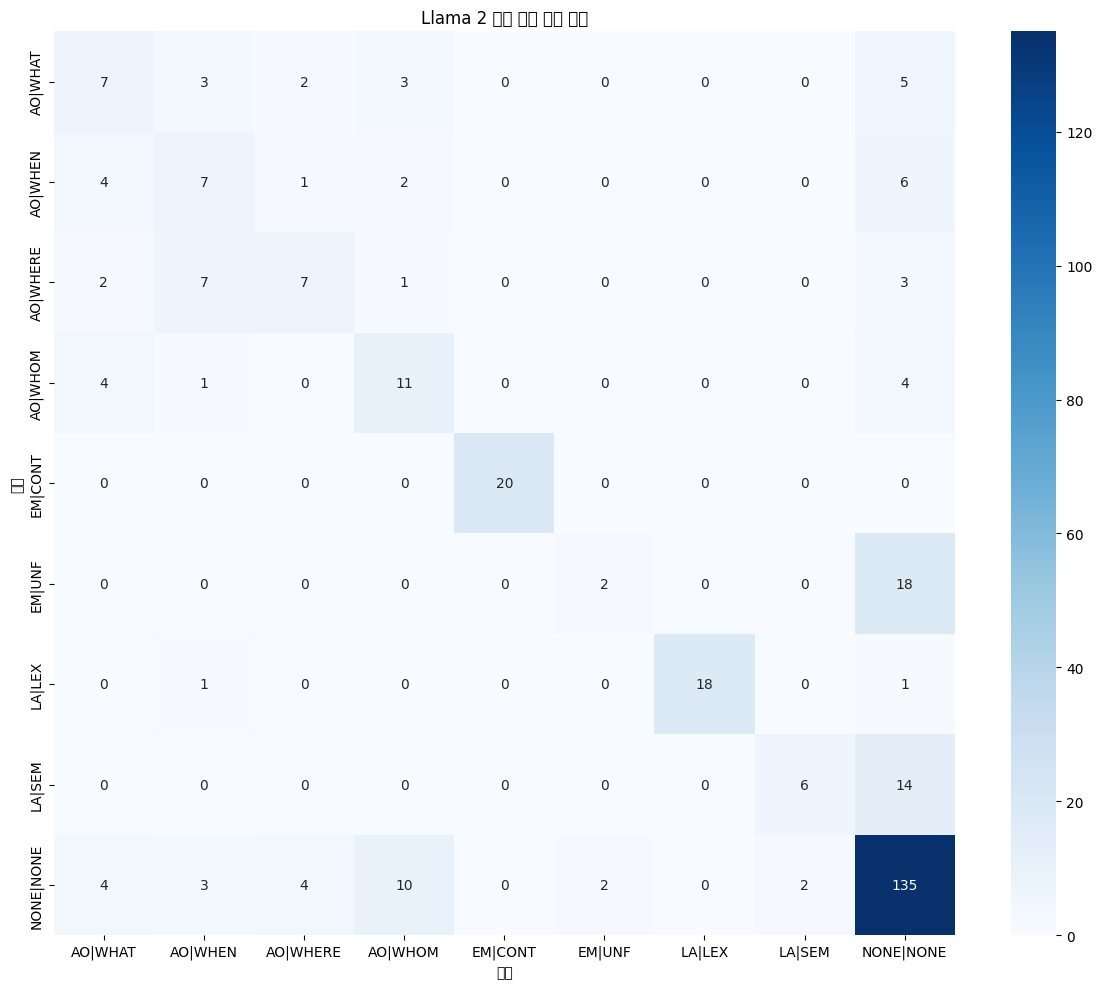

In [ ]:
# 혼동 행렬 생성 및 시각화

try:
    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # 레이블 추출
    y_true = [r["expected"] for r in all_results]
    y_pred = [r["predicted"] for r in all_results]

    # 고유 레이블
    unique_labels = sorted(list(set(y_true + y_pred)))

    if len(unique_labels) > 20:
        from collections import Counter
        label_counts = Counter(y_true + y_pred)
        unique_labels = [label for label, _ in label_counts.most_common(20)]

    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    cm_df = pd.DataFrame(cm, index=unique_labels, columns=unique_labels)

    # 시각화
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('예측')
    plt.ylabel('실제')
    plt.title('Llama 2 분류 결과 혼동 행렬')
    plt.tight_layout()
    plt.show()

except ImportError:
    print("시각화 라이브러리가 없어 혼동 행렬을 표시할 수 없습니다.")

In [ ]:
# 각 split 개수 확인

print("=== 데이터셋 개수 확인 ===")
print(f"Train: {len(dataset_messages['train'])}개")
print(f"Validation: {len(dataset_messages['validation'])}개")
print(f"Test: {len(dataset_messages['test'])}개")

# 비율 계산
total = len(dataset_messages['train']) + len(dataset_messages['validation']) + len(dataset_messages['test'])
print(f"\n총합: {total}개")
print(f"\n비율:")
print(f"  Train: {len(dataset_messages['train'])/total*100:.1f}%")
print(f"  Valid: {len(dataset_messages['validation'])/total*100:.1f}%")
print(f"  Test: {len(dataset_messages['test'])/total*100:.1f}%")

=== 데이터셋 개수 확인 ===
Train: 2561개
Validation: 320개
Test: 321개

총합: 3202개

비율:
  Train: 80.0%
  Valid: 10.0%
  Test: 10.0%
